# Analysis on intermediate outputs of quantized models VS FP models

## 
Can we compare intermediate outputs layer-by-layer between the FP32 model, QAT model, and PTQ model to identify where significant deviations occur in quantization?


In [1]:
import torch
import yaml
from src.utils import *
from src.data_loader import get_data_loaders
from src.models.cnn_model import M5, QATM5, PTQM5
fp_dict = torch.load("../models/cnn_fp32_model.pth")
qat_from_scratch_dict = torch.load("../models/cnn_qat_model_from_scratch.pth")
qat_from_pretrained_dict = torch.load("../models/cnn_qat_model.pth")
ptq_dict = torch.load("../models/cnn_ptq_model.pth")

/root/miniconda3/envs/audioml/lib/python3.13/site-packages/torch/_utils.py:431: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [2]:
data_config = {
    "raw_dir": "../data/raw",
    "processed_dir": "./data/processed",
    "sample_rate": 8000,
    "batch_size": 256,
    "version": "v0.1"
}
train_loader, test_loader, _ = get_data_loaders(data_config)

In [3]:
# Load FP model
config_fp = '../configs/cnn_fp32.yaml'
with open(config_fp, 'r') as f:
    config = yaml.safe_load(f)
    
params_fp = config["model"]["base_cnn"]
model_fp = M5(
            n_input=params_fp["n_input"],
            n_output=params_fp["n_output"],
            stride=params_fp["stride"],
            n_channel=params_fp["n_channel"],
            conv_kernel_sizes=params_fp["conv_kernel_sizes"]
        )
model_fp.load_state_dict(fp_dict)
model_fp.to('cpu')

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=Fa

In [4]:
import copy
# Load QAT model
config_QAT = '../configs/cnn_qat.yaml'
with open(config_QAT, 'r') as f:
    config = yaml.safe_load(f)
    
params_qat = config["model"]["base_cnn"]
model_qat = QATM5(
            n_input=params_qat["n_input"],
            n_output=params_qat["n_output"],
            stride=params_qat["stride"],
            n_channel=params_qat["n_channel"],
            conv_kernel_sizes=params_qat["conv_kernel_sizes"]
        )
# Fuse and prepare for quantization
model_qat.eval()
model_qat.fuse_model()
model_qat.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')

model_qat.train()
torch.ao.quantization.prepare_qat(model_qat, inplace=True)

# Convert to quantized model
model_qat.eval()
model_qat = torch.ao.quantization.convert(model_qat, inplace=False)
model_qat_from_scratch = model_qat
model_qat_from_pretrained = copy.deepcopy(model_qat)

# Load checkpoint
model_qat_from_scratch.load_state_dict(qat_from_scratch_dict)
model_qat_from_scratch.to('cpu')
model_qat_from_pretrained.load_state_dict(qat_from_pretrained_dict)
model_qat_from_pretrained.to('cpu')

/root/miniconda3/envs/audioml/lib/python3.13/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/root/miniconda3/envs/audioml/lib/python3.13/site-packages/torch/ao/quantization/utils.py:408: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


QATM5(
  (conv1): QuantizedConvReLU1d(1, 32, kernel_size=(80,), stride=(16,), scale=0.38135969638824463, zero_point=0)
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU1d(32, 32, kernel_size=(3,), stride=(1,), scale=0.13234169781208038, zero_point=0)
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): QuantizedConvReLU1d(32, 64, kernel_size=(3,), stride=(1,), scale=0.05996142700314522, zero_point=0)
  (bn3): Identity()
  (relu3): Identity()
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): QuantizedConvReLU1d(64, 64, kernel_size=(3,), stride=(1,), scale=0.13576824963092804, zero_point=0)
  (bn4): Identity()
  (relu4): Identity()
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_features

In [5]:
# Load PTQ model
config_PTQ = '../configs/cnn_ptq.yaml'
with open(config_PTQ, 'r') as f:
    config = yaml.safe_load(f)
    
params_PTQ = config["model"]["base_cnn"]
model_PTQ = PTQM5(
            n_input=params_PTQ["n_input"],
            n_output=params_PTQ["n_output"],
            stride=params_PTQ["stride"],
            n_channel=params_PTQ["n_channel"],
            conv_kernel_sizes=params_PTQ["conv_kernel_sizes"]
        )
# Fuse and prepare for quantization
model_PTQ.eval()
model_PTQ.fuse_model()
model_PTQ.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')

model_PTQ.train()
torch.ao.quantization.prepare_qat(model_PTQ, inplace=True)

# Convert to quantized model
model_PTQ.eval()
model_PTQ = torch.ao.quantization.convert(model_PTQ, inplace=False)

# Load checkpoint
model_PTQ.load_state_dict(ptq_dict)
model_PTQ.to('cpu')

PTQM5(
  (conv1): QuantizedConvReLU1d(1, 32, kernel_size=(80,), stride=(16,), scale=0.20977337658405304, zero_point=0)
  (bn1): Identity()
  (relu1): Identity()
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConvReLU1d(32, 32, kernel_size=(3,), stride=(1,), scale=0.09717676043510437, zero_point=0)
  (bn2): Identity()
  (relu2): Identity()
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): QuantizedConvReLU1d(32, 64, kernel_size=(3,), stride=(1,), scale=0.036625321954488754, zero_point=0)
  (bn3): Identity()
  (relu3): Identity()
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): QuantizedConvReLU1d(64, 64, kernel_size=(3,), stride=(1,), scale=0.10515490174293518, zero_point=0)
  (bn4): Identity()
  (relu4): Identity()
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_feature

In [6]:
# ADD HOOKS
activation_fp = {}
activation_qat_from_scratch = {}
activation_qat_from_pretrained = {}
activation_PTQ = {}
def get_activation_fp(name):
    def hook(model, input, output):
        activation_fp[name] = output.detach().cpu()
    return hook

def get_activation_qat_from_scratch(name):
    def hook(model, input, output):
        activation_qat_from_scratch[name] = output.detach().cpu()
    return hook

def get_activation_qat_from_pretrained(name):
    def hook(model, input, output):
        activation_qat_from_pretrained[name] = output.detach().cpu()
    return hook

def get_activation_PTQ(name):
    def hook(model, input, output):
        activation_PTQ[name] = output.detach().cpu()
    return hook

model_fp.pool1.register_forward_hook(get_activation_fp("layer1"))
model_fp.pool2.register_forward_hook(get_activation_fp("layer2"))
model_fp.pool3.register_forward_hook(get_activation_fp("layer3"))
model_fp.pool4.register_forward_hook(get_activation_fp("layer4"))

model_qat_from_scratch.pool1.register_forward_hook(get_activation_qat_from_scratch("layer1"))
model_qat_from_scratch.pool2.register_forward_hook(get_activation_qat_from_scratch("layer2"))
model_qat_from_scratch.pool3.register_forward_hook(get_activation_qat_from_scratch("layer3"))
model_qat_from_scratch.pool4.register_forward_hook(get_activation_qat_from_scratch("layer4"))

model_qat_from_pretrained.pool1.register_forward_hook(get_activation_qat_from_pretrained("layer1"))
model_qat_from_pretrained.pool2.register_forward_hook(get_activation_qat_from_pretrained("layer2"))
model_qat_from_pretrained.pool3.register_forward_hook(get_activation_qat_from_pretrained("layer3"))
model_qat_from_pretrained.pool4.register_forward_hook(get_activation_qat_from_pretrained("layer4"))

model_PTQ.pool1.register_forward_hook(get_activation_PTQ("layer1"))
model_PTQ.pool2.register_forward_hook(get_activation_PTQ("layer2"))
model_PTQ.pool3.register_forward_hook(get_activation_PTQ("layer3"))
model_PTQ.pool4.register_forward_hook(get_activation_PTQ("layer4"))

# Get one batch from the train loader
inputs, labels = next(iter(train_loader))   
# inputs shape: (B: 256, C: 1, sample_rate * time: 8000)

# Use the first sample only, keeping batch dimension
input_tensor = inputs[0].unsqueeze(0) 

# Run inference
model_fp.eval()
with torch.no_grad():
    _ = model_fp(inputs)

model_qat_from_scratch.eval()
with torch.no_grad():
    _ = model_qat_from_scratch(inputs)

model_qat_from_pretrained.eval()
with torch.no_grad():
    _ = model_qat_from_pretrained(inputs)

model_PTQ.eval()
with torch.no_grad():
    _ = model_PTQ(inputs)

## Metrics

- Mean Squared Error (MSE): Measures average squared difference—sensitive to large deviations.

$$
\text{MSE}(A, B) = \frac{1}{N} \sum_i (A_i - B_i)^2
$$

- Mean Absolute Error (MAE): Less sensitive to outliers, measures the average magnitude of error.

$$
\text{MAE}(A, B) = \frac{1}{N} \sum_i |A_i - B_i|
$$

- Cosine Similarity

$$
\text{cosine}(A, B) = \frac{A \cdot B}{\|A\|\|B\|}
$$

- Standard Deviation (Std)

In [8]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compare_outputs(ref, test, name):
    test = test.dequantize()

    mse = F.mse_loss(test, ref).item()
    mae = F.l1_loss(test, ref).item()
    cosine = F.cosine_similarity(ref.flatten(), test.flatten(), dim=0).item()

    print(f"{name}: MSE={mse:.4e}, MAE={mae:.4e}, Cosine={cosine:.4f}")

for k in activation_fp.keys():
    compare_outputs(activation_fp[k], activation_qat_from_scratch[k], f"{k} (FP vs QAT from scratch)")
    compare_outputs(activation_fp[k], activation_qat_from_pretrained[k], f"{k} (FP vs QAT from pretrained)")
    compare_outputs(activation_fp[k], activation_PTQ[k], f"{k} (FP vs PTQ)")

layer1 (FP vs QAT from scratch): MSE=1.1072e+00, MAE=3.5092e-01, Cosine=0.4977
layer1 (FP vs QAT from pretrained): MSE=8.4135e-03, MAE=5.9589e-02, Cosine=0.9972
layer1 (FP vs PTQ): MSE=4.8864e-03, MAE=4.0976e-02, Cosine=0.9982
layer2 (FP vs QAT from scratch): MSE=3.2888e+00, MAE=7.6907e-01, Cosine=0.3017
layer2 (FP vs QAT from pretrained): MSE=1.6345e-02, MAE=6.2840e-02, Cosine=0.9951
layer2 (FP vs PTQ): MSE=2.4580e-03, MAE=3.2596e-02, Cosine=0.9975
layer3 (FP vs QAT from scratch): MSE=1.1935e+01, MAE=1.6439e+00, Cosine=0.2990
layer3 (FP vs QAT from pretrained): MSE=1.8173e-02, MAE=7.6827e-02, Cosine=0.9747
layer3 (FP vs PTQ): MSE=9.0402e-03, MAE=5.4989e-02, Cosine=0.9804
layer4 (FP vs QAT from scratch): MSE=4.1149e+01, MAE=3.8836e+00, Cosine=0.3928
layer4 (FP vs QAT from pretrained): MSE=4.9312e-01, MAE=4.8908e-01, Cosine=0.9781
layer4 (FP vs PTQ): MSE=3.0411e-01, MAE=3.9042e-01, Cosine=0.9789


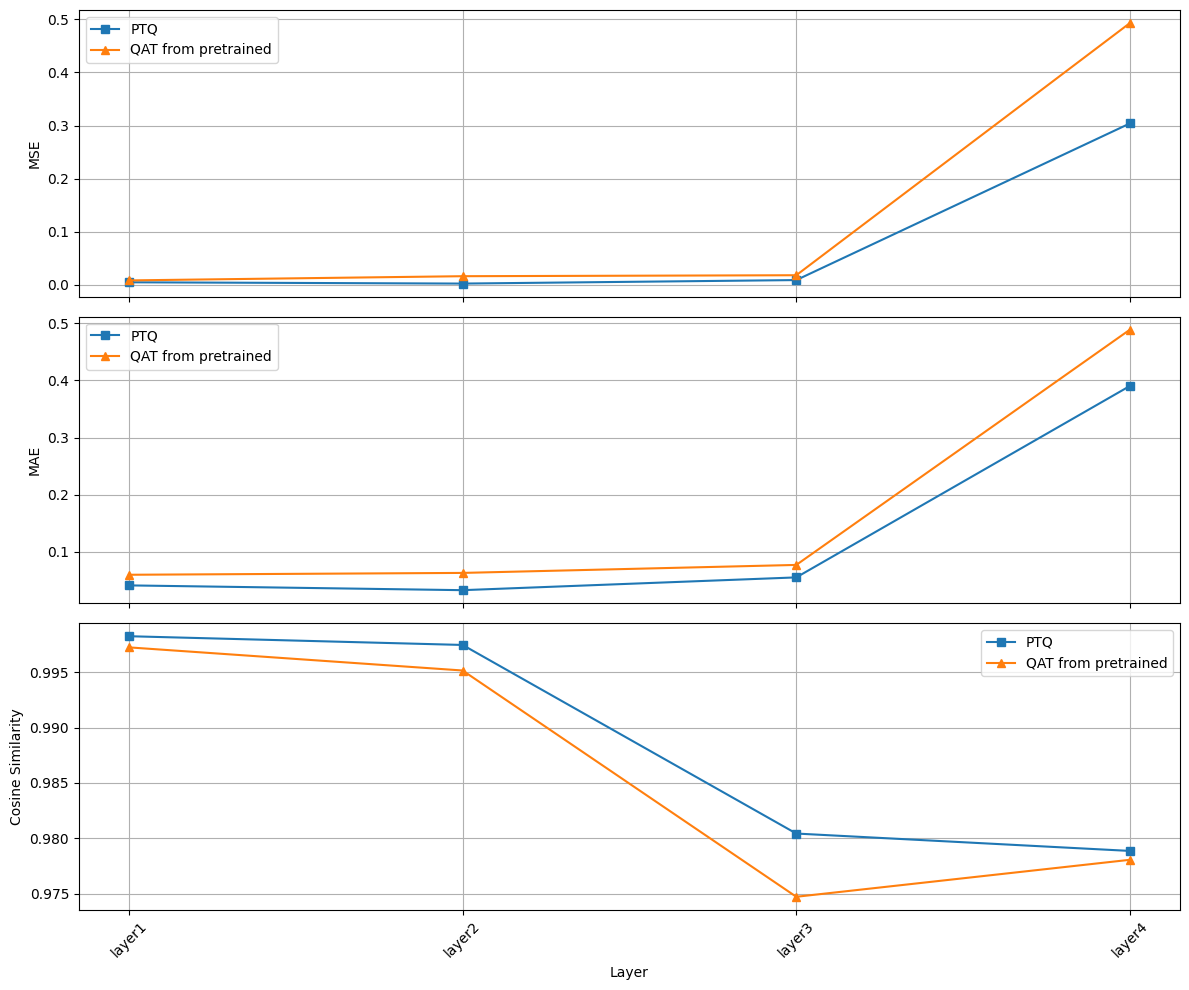

In [10]:
def compare_layer_outputs_plot(activation_fp, activation_qat_from_scratch, activation_qat_from_pretrained, activation_PTQ):
    layers = list(activation_fp.keys())
    mse_qat_from_scratch, mae_qat_from_scratch, cos_qat_from_scratch = [], [], []
    mse_qat_from_pretrained, mae_qat_from_pretrained, cos_qat_from_pretrained = [], [], []
    mse_ptq, mae_ptq, cos_ptq = [], [], []

    for layer in layers:
        ref = activation_fp[layer]
        qat_from_scratch = activation_qat_from_scratch[layer].dequantize()
        qat_from_pretrained = activation_qat_from_pretrained[layer].dequantize()
        ptq = activation_PTQ[layer].dequantize()

        # mse_qat_from_scratch.append(F.mse_loss(ref, qat_from_scratch).item())
        # mae_qat_from_scratch.append(F.l1_loss(ref, qat_from_scratch).item())
        # cos_qat_from_scratch.append(F.cosine_similarity(ref.flatten(), qat_from_scratch.flatten(), dim=0).item())

        mse_qat_from_pretrained.append(F.mse_loss(ref, qat_from_pretrained).item())
        mae_qat_from_pretrained.append(F.l1_loss(ref, qat_from_pretrained).item())
        cos_qat_from_pretrained.append(F.cosine_similarity(ref.flatten(), qat_from_pretrained.flatten(), dim=0).item())

        mse_ptq.append(F.mse_loss(ref, ptq).item())
        mae_ptq.append(F.l1_loss(ref, ptq).item())
        cos_ptq.append(F.cosine_similarity(ref.flatten(), ptq.flatten(), dim=0).item())

    x = range(len(layers))
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # axs[0].plot(x, mse_qat_from_scratch, label='QAT from scratch', marker='o')
    axs[0].plot(x, mse_ptq, label='PTQ', marker='s')
    axs[0].plot(x, mse_qat_from_pretrained, label='QAT from pretrained', marker='^')
    axs[0].set_ylabel('MSE')
    axs[0].legend()
    axs[0].grid(True)

    # axs[1].plot(x, mae_qat_from_scratch, label='QAT', marker='o')
    axs[1].plot(x, mae_ptq, label='PTQ', marker='s')
    axs[1].plot(x, mae_qat_from_pretrained, label='QAT from pretrained', marker='^')
    axs[1].set_ylabel('MAE')
    axs[1].legend()
    axs[1].grid(True)

    # axs[2].plot(x, cos_qat_from_scratch, label='QAT', marker='o')
    axs[2].plot(x, cos_ptq, label='PTQ', marker='s')
    axs[2].plot(x, cos_qat_from_pretrained, label='QAT from pretrained', marker='^')
    axs[2].set_ylabel('Cosine Similarity')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(layers, rotation=45)
    axs[2].legend()
    axs[2].grid(True)

    plt.xlabel("Layer")
    plt.tight_layout()
    plt.show()

compare_layer_outputs_plot(activation_fp, activation_qat_from_scratch, activation_qat_from_pretrained, activation_PTQ)

## 1. What each metric measures
### 1.1. MSE and MAE:
- Measure the absolute magnitude of differences between values.
- Sensitive to scaling and bias.
- Large MSE/MAE means the outputs deviate significantly in value.

### 1.2. Cosine Similarity:
- Measures the angle between two vectors, i.e., their direction.
- Insensitive to magnitude — only cares about relative orientation.
- High cosine similarity can still happen even if the values are scaled or offset consistently.

## 2. Observation of the results
- The trending of PTQ (VS FP) and QAT (VS FP) are similar.
- In Layer 4, although QAT from pretrained and PTQ show large MAE/MSE, they still point in roughly the same direction in high-dimensional space.

In [11]:
# About Qconfig
# https://pytorch.org/docs/stable/generated/torch.ao.quantization.observer.MinMaxObserver.html
qconfig = torch.ao.quantization.get_default_qconfig('x86')

# Instantiate the observers
activation_observer = qconfig.activation()
weight_observer = qconfig.weight()

# Print the quantization schemes
print("Activation Observer qscheme:", activation_observer.qscheme) #  (torch.per_tensor_affine,)
print(activation_observer)
print("Weight Observer qscheme:", weight_observer.qscheme) #  (torch.per_channel_symmetric,)
print(weight_observer)

# Check quantization ranges
print("\nActivation Observer quant_min/max:", activation_observer.quant_min, activation_observer.quant_max) #  (int)(0, 127)
print("Weight Observer quant_min/max:", weight_observer.quant_min, weight_observer.quant_max) # (int)(-128, 127)

# QConfig(
#     activation=functools.partial(
#         <class 'torch.ao.quantization.observer.HistogramObserver'>, 
#         reduce_range=True){}, 
#      weight=functools.partial(
#         <class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, 
#         dtype=torch.qint8, 
#         qscheme=torch.per_channel_symmetric
#         ){}
#     )

Activation Observer qscheme: torch.per_tensor_affine
HistogramObserver(min_val=inf, max_val=-inf)
Weight Observer qscheme: torch.per_channel_symmetric
PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))

Activation Observer quant_min/max: 0 127
Weight Observer quant_min/max: -128 127


/root/miniconda3/envs/audioml/lib/python3.13/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
